# CNN Fake News

## Imports

In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords # remove stopword
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ieie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ieie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ieie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ieie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Vectorization classes

### The Vocabulary

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        # news_vocab._token_to_idx: {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'jobs': 4, 'tax': 5, 'cuts': 6,  
        #                             ......, 'shiite': 3407, 'ghraib': 3408}
        # category_vocab._token_to_idx: {'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}
        
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token             # for paddding, e.g., Wall St. Bears Claw Back Into the Black (Reuters)
                                                  #               -> [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)            # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)              # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token)  # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)      # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

### The Vectorizer

In [4]:
class NewsVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, news_vocab, category_vocab):
        self.news_vocab = news_vocab
        self.category_vocab = category_vocab

    def vectorize(self, text, vector_length=-1):
        """
        Args:
            text (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized text (numpy.array)
        """
        """    
        mask_index is 0
        unk_index is 1
        begin_seq_index is 2
        end_seq_index is 3
        
        When text is "Wall St. Bears Claw Back Into the Black (Reuters)"; max vector length is 29 in current dataset 
        
        out_vector = [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
        
        """
        
        indices = [self.news_vocab.begin_seq_index]
        indices.extend(self.news_vocab.lookup_token(token) 
                       for token in text.split(" "))
        indices.append(self.news_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.news_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, news_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the NewsVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for text in news_df.text:
            for token in text.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        news_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                news_vocab.add_token(word)
        
        return cls(news_vocab, category_vocab)

### The Dataset

In [5]:
def text_preprocessing(text):
    text = text.lower() # case folding
    text = re.sub('&\w*\;\w*', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r"[^a-z]+", r" ", text) # Regulation, remove special charecters
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    lemmatizer=WordNetLemmatizer()
    # remove stopwords and lemmatization
    result = [lemmatizer.lemmatize(i) for i in tokens if not i in stop_words]
    result = result[:1000]
    '''
    # bigram
    bigram_result = []
    bigram_list = ngrams(result,2)
    for word_set in bigram_list:
        for word in word_set:
            bigram_result.append(word)
    '''
    return result

test_str_1 = "This is sentence to test the effect of preprocessing... Yeah~\nCool!fac  feae ge fe ga 🪣🛀🎀 ☏☢︎⏥␘⍎ (>╹ω╹<)喵"
test_str_2 = "Glaxo Settles Paxil 'Suicide Pill' Suit.  NEW YORK (Reuters) - GlaxoSmithKline Plc &lt;A HREF=http://www.investor.reuters.com/FullQuote.aspx?ticker=GSK.L target=/stocks/quickinfo/fullquote""&gt;GSK.L&lt;/A&gt; has agreed  to release all clinical studies of its drugs to settle a  lawsuit that accused it of withholding negative information  about the antidepressant Paxil, the New York Attorney General's  office said on Thursday."
list = text_preprocessing(test_str_2)
' '.join(list)

'glaxo settle paxil suicide pill suit new york reuters glaxosmithkline plc href target stock quickinfo fullquote l agreed release clinical study drug settle lawsuit accused withholding negative information antidepressant paxil new york attorney general office said thursday'

In [6]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (NewsVectorizer): vectorizer instatiated from dataset
        """
        self.news_df = news_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, news_df.text)) + 2
        

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = news_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        news_df = pd.read_csv(news_csv)
        
        for index, text in enumerate(news_df.text):
            processed_list = text_preprocessing(text)
            news_df.text[index] = ' '.join(processed_list)

        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        news_vector = \
            self._vectorizer.vectorize(row.text, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': news_vector,     # e.g., "Wall St. Bears Claw Back Into the Black (Reuters)" 
                                            # -> [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
                'y_target': category_index} # e.g., 2

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: NewsClassifier

In [7]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size,   # 100
                                    num_embeddings=num_embeddings,  # 3409
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True) # when freeze=True (default), 
                                                                           # the tensor does not get updated in the learning process.
               
        # in_channels: embedding_size; out_channels: # of filters; kernel_size = n-gram size
        # number of parameters: (# of filters, embedding_size, n-gram size), (100, 100, 2) for 2-gram
        self.conv1d_4gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=4)       
        self.conv1d_3gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=3)                          
        self.conv1d_2gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=2)                   

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels*3, hidden_dim) # input:concatination of conv1d_4gram, conv1d_3gram, conv1d_2gram outputs 
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)    # (batch, seq_len) -> (batch, seq_len, features)
                                                        # rearange (batch, seq_len, features) to (batch, features, seq_len) 
                                                        # E.g.,    (128,   29,      100)      to (128,   100,      29)

        features = F.elu(self.conv1d_4gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
                                                        # activation function similar to leaky RELU(); can use F.relu() instead
        # max/average and remove the extra dimension
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_4gram = F.max_pool1d(features, remaining_size).squeeze(dim=2) # features_4gram: (batch, num_channels);kernel_size=remaining_size   
        #features_4gram = F.avg_pool1d(features, remaining_size).squeeze(dim=2)   
        
        features = F.elu(self.conv1d_3gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_3gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)    # features_3gram: (batch, num_channels)

        features = F.elu(self.conv1d_2gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_2gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)    # features_2gram: (batch, num_channels) 
 
        features = torch.cat([features_4gram, features_3gram, features_2gram], dim=1)
            
        features = F.dropout(features, p=self._dropout_p, training=self.training)
        
        # mlp classifier
        intermediate_vector = F.dropout(F.relu(self.fc1(features)), p=self._dropout_p, training=self.training)
        prediction_vector = self.fc2(intermediate_vector)  # (batch, num_classes)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training Routine

### Helper functions

In [8]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [9]:
def set_seed_everywhere(seed, cuda, mps):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        print("cuda manual seed", seed)
        torch.cuda.manual_seed_all(seed)
    try:
        if mps:
            print("mps manual seed", seed)
            torch.mps.manual_seed(seed)
    except:
        pass

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r", encoding='utf8') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

### Settings and some prep work

In [10]:
from argparse import Namespace

In [11]:
args = Namespace(
    # Data and Path hyper parameters
    news_csv="../data/processed/fake_or_real_news_with_splits.csv",
    model_state_file="model_cnn_Fake_News.pth",
    save_dir="../model_storage/Fake_News",
    # Model hyper parameters
    glove_filepath='../data/glove/glove.6B.100d.txt', 
    use_glove=True,
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=64, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True,
    mps=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA for Nvidia
if not torch.cuda.is_available():
    args.cuda = False

# Check MPS for Mac
try:
    if not torch.backends.mps.is_available():
        args.mps = False
except:
    args.mps = False

args.device = torch.device("cuda" if args.cuda else "mps" if args.mps else "cpu")
print("Using CUDA: {}".format(args.cuda))
print("Using MPS: {}".format(args.mps))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda, args.mps)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	../model_storage/Fake_News\model_cnn_Fake_News.pth
Using CUDA: True
Using MPS: False
cuda manual seed 1337


### Initializations

In [12]:
args.use_glove = True

In [13]:
# create dataset and vectorizer
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.news_vocab._token_to_idx.keys()  # 3409 unique words
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,     # embeddings: (3409, 100)
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

classifier = NewsClassifier(embedding_size=args.embedding_size,          # e.g, 100
                            num_embeddings=len(vectorizer.news_vocab),  # e.g., 3409
                            num_channels=args.num_channels,              # e.g., 100
                            hidden_dim=args.hidden_dim,                  # e.g., 100
                            num_classes=len(vectorizer.category_vocab),  # e.g., 4
                            dropout_p=args.dropout_p,                    # e.g., 0.1
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

C:\Users\ieie\AppData\Local\Temp\ipykernel_22452\1110265742.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df.text[index] = ' '.join(processed_list)


Using pre-trained embeddings


In [14]:
print(vectorizer.news_vocab._token_to_idx)

{'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'nothing': 4, 'good': 5, 'come': 6, 'election': 7, 'posted': 8, 'november': 9, 'charles': 10, 'smith': 11, 'overwhelming': 12, 'consensus': 13, 'across': 14, 'political': 15, 'spectrum': 16, 'thing': 17, 'go': 18, 'like': 19, 'country': 20, 'deeply': 21, 'divided': 22, 'every': 23, 'institution': 24, 'two': 25, 'party': 26, 'mainstream': 27, 'medium': 28, 'department': 29, 'justice': 30, 'cover': 31, 'ups': 32, 'collusion': 33, 'worse': 34, 'win': 35, 'enter': 36, 'presidency': 37, 'without': 38, 'mandate': 39, 'nation': 40, 'corruption': 41, 'require': 42, 'hitting': 43, 'bottom': 44, 'drug': 45, 'incapable': 46, 'making': 47, 'truly': 48, 'positive': 49, 'change': 50, 'hit': 51, 'absolute': 52, 'tolerance': 53, 'corrupt': 54, 'system': 55, 'poisoning': 56, 'one': 57, 'injection': 58, 'cash': 59, 'pay': 60, 'play': 61, 'time': 62, 'core': 63, 'politics': 64, 'usual': 65, 'indeed': 66, 'flying': 67, 'cliff': 68, 'complete': 69, 'destr

In [15]:
print(vectorizer.category_vocab._token_to_idx)

{'FAKE': 0, 'REAL': 1}


In [16]:
dataset._max_seq_length

1002

### Training loop

In [17]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data']) # (batch, seq_len) -> (batch, num_classes)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

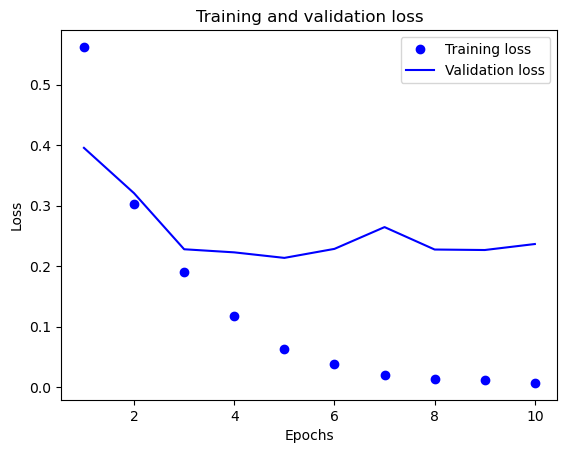

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

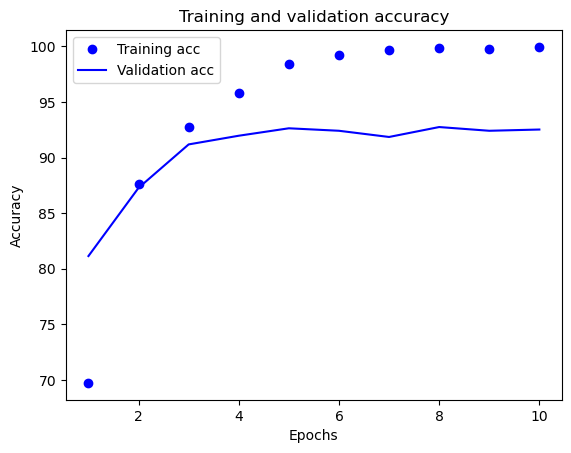

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'])) # load the best model

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_category_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_category_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [21]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.24122860814843858;
Test Accuracy: 92.07589285714286


In [22]:
classes = []
for i in range(len(dataset._vectorizer.category_vocab)):
    classes.append(dataset._vectorizer.category_vocab.lookup_index(i))
print(classes)

['FAKE', 'REAL']


In [23]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm = confusion_matrix(y_category_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       FAKE  REAL
Predicted            
FAKE        426    48
REAL         23   399


In [24]:
print(classification_report(y_category_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       449
           1       0.95      0.89      0.92       447

    accuracy                           0.92       896
   macro avg       0.92      0.92      0.92       896
weighted avg       0.92      0.92      0.92       896



### Inference

In [25]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text 

In [26]:
def predict_category(title, classifier, vectorizer, max_length):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category, 
            'probability': probability_values.item()}

In [27]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.text[dataset.val_df.category==cat].tolist()[:5]
    return samples

val_samples = get_samples() # first 5 titles of each category from validation dataset

In [28]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, classifier, 
                                      vectorizer, dataset._max_seq_length)
        print("Prediction: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + Sample: {}".format(sample))
    print("-"*30 + "\n")

True Category: FAKE
Prediction: FAKE (p=1.00)
	 + Sample: hillary clinton postapocalyptic hellscape plan hillary clinton postapocalyptic hellscape plan important avoid age peace hillary clinton postapocalyptic hellscape plan b look email even com wrong comdingdangaramaramaflimflam mail question comment site godlike production glp registered trademark zero point ltd godlike website design copyright godlikeproductions com page generated query
Prediction: FAKE (p=1.00)
	 + Sample: russophobia war party propaganda information russophobia war party propaganda world reactionary regime head chopping terror sponsoring saudi arabian kleptocracy awarded chair un human right council russia kicked travesty engineered superpower lie punish moscow resisting u led war sectarian massacre regime change syria war party march cheer corporate medium hillary even elected yet margaret kimberley attempt stop fighting rejected u nato sealed fate syrian people november information clearing house bar russia inv

### Excercise:

1. Change F.max_pool1d() to F.avg_pool1d().
2. Change use_glove=True to use_glove=False.
3. Change other hyperparameters.
